### Baseline

Обучать будем дерево решений. Импортируем необходимые пакеты для работы с моделью

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import PredictionErrorDisplay

from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import GridSearchCV

Определим функцию для вывода метрик для регрессионной задачи

In [3]:
def calc_regression_metrics(y_true, y_pred):
    print(
        '\tMAE: ', mae(y_true, y_pred), '\n',
        '\tMSE: ', mse(y_true, y_pred), '\n',
        '\tR2: ', r2(y_true, y_pred), '\n',
        sep=''
    )

Поделим набор данных на train и test

In [4]:
dmnds = pd.read_csv('../dataset/diamonds.csv')
dmnds

,carat,cut,color,clarity,depth,table,price,x,y,z,d,table_size
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43000,3.965,2.18075
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31000,3.865,2.35765
2,0.23,Good,E,VS1,61.8,57.0,327,4.05,4.07,2.50908,4.060,2.31420
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63000,4.215,2.44470
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75000,4.345,2.52010
...,...,...,...,...,...,...,...,...,...,...,...,...
53789,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50000,5.755,3.28035
53790,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61000,5.720,3.14600
53791,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56000,5.670,3.40200
53792,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74000,6.135,3.55830


In [5]:
X = dmnds.drop(columns=['price'])
y = dmnds['price']

num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'd', 'table_size']
cat_cols = ['cut', 'color', 'clarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Создадим pipeline для предсказания с базовым набором признаков (только числовые)

In [6]:
np.random.seed(42)
# baseline модель с только числовыми признаками
num_col_trans = ColumnTransformer([
    ('num_std', StandardScaler(), num_cols),
    # ('ohe_cat', OneHotEncoder(), cat_cols)
])
num_cals_pipe = Pipeline([
    ('prep', num_col_trans),
    ('model', DecisionTreeRegressor())
])

Сделаем предсказание и рассмотрим метрики

In [7]:
np.random.seed(42)
num_cals_pipe.fit(X_train, y_train)
y_test_pred = num_cals_pipe.predict(X_test)
y_train_pred = num_cals_pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

Train metrics:
	MAE: 16.34216147858692
	MSE: 14069.53301838117
	R2: 0.9991281638911479

Test metrics:
	MAE: 1010.944095639371
	MSE: 3442956.774780585
	R2: 0.7758104189218387



Как видим, метрики на train довольно хорошая, однако метрика на test просели, что говорит о том, что дерево переобучилось.

Попробуем пройтись по train с помощью кросс-валидации

In [8]:
np.random.seed(42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(num_cals_pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean()

0.7757966477647882

Видно, что в общем и целом метрики падают, когда модель предсказывает ранее невидиме данные.

Также стоит обратить внимание на то, что MSE довольно большой, что может говорить о том, что диапазон таргета в трейне меньше диапазона в тесте и дерево не может "выйти" за диапазон тренировочного таргета.

Посмотрим на PredictionErrorDisplay

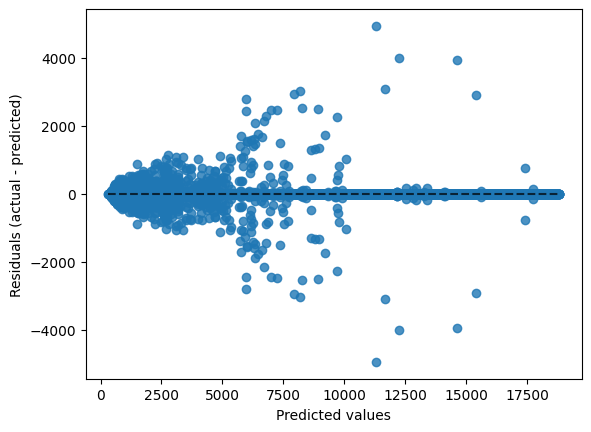

In [9]:
PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred).plot()

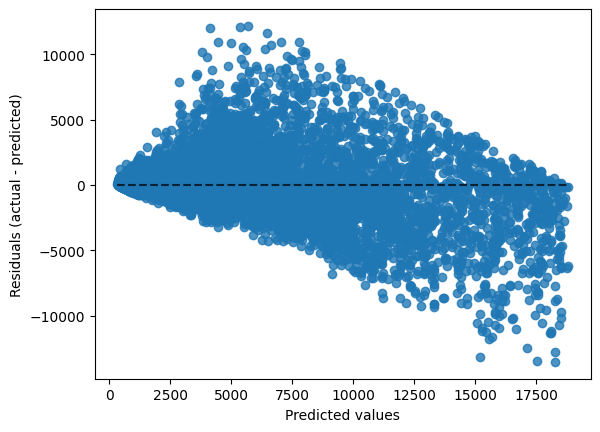

In [10]:
PredictionErrorDisplay(y_true=y_test, y_pred=y_test_pred).plot()

Видно, что на train модель ошибается меньше, однако ошибки всё ещё есть. Что может говорить о том, что нам не хватает фичей для определения более точной цены, ибо в нашем случае есть лишь размерные фичи, но нет фичей огранки и цвета, что может тоже существенно повлиять на результат предсказания.

Также на по предсказанию на test видно, что в некоторых случаях модель иногда ошибается, предсказывая слишком высокую цену или слишком маленькую. Отсюда возникает существенный рост метрики MSE.

Предположение о том, что дерево при обучении не "увидело" нужный диапазон цен можно опровергнуть, судя по Predicted values в диаграммах.

In [11]:
num_cals_pipe['model'].feature_importances_

array([0.63411626, 0.01882   , 0.00444534, 0.01470845, 0.27505882,
       0.0155361 , 0.01367323, 0.0236418 ])

Рассмотрим feature importances дерева. 

Можно обратить внимание на то, что существенное влияние на результат предсказания оказывает вес carat и диаметр y.
Стоит попробовать оставить только carat и y

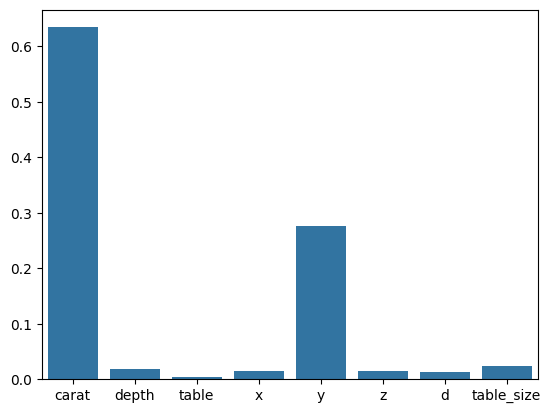

In [12]:
sns.barplot(num_cals_pipe['model'].feature_importances_)
plt.xticks(range(len(num_cols)), num_cols);

In [13]:
np.random.seed(42)
col_trans = ColumnTransformer([
    ('num_std', StandardScaler(), ['carat', 'y']),
    # ('ohe_cat', OneHotEncoder(), cat_cols)
])
pipe = Pipeline([
    ('prep', col_trans),
    ('model', DecisionTreeRegressor())
])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val: ', cross_val_score(pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 643.4760393664817
	MSE: 1346908.1671022673
	R2: 0.9165371605544137

Test metrics:
	MAE: 859.6001195592048
	MSE: 2403455.034285172
	R2: 0.8434980127477989

cross-val:  0.8380872438981537


Использование только важных фич относительно feature importances положительно сказалось на R2 метрике. Вероятно, на это повлияло снижение шума в остальных переменных.

### Улучшение модели

#### Добавление категориальных признаков

Попробуем использовать выделенные числовые переменные и категориальные.

In [14]:
np.random.seed(42)
col_trans = ColumnTransformer([
    ('num_std', StandardScaler(), ['carat', 'y']),
    ('cat_ordinal', OrdinalEncoder(), [])
])
pipe = Pipeline([
    ('prep', col_trans),
    ('model', DecisionTreeRegressor())
])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val:', cross_val_score(pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 643.4760393664817
	MSE: 1346908.1671022673
	R2: 0.9165371605544137

Test metrics:
	MAE: 859.6001195592048
	MSE: 2403455.034285172
	R2: 0.8434980127477989

cross-val: 0.8380872438981537


В видно, что метрики сущестенно улучшились при добавлении категориальных колонок.

Посмотрим на feature importances

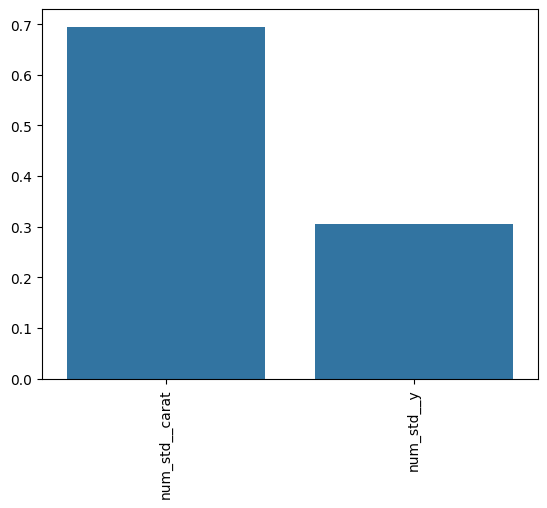

In [15]:
features = pipe['prep'].get_feature_names_out()
sns.barplot(pipe['model'].feature_importances_)
plt.xticks(range(len(features)), features, rotation=90);

По feature importances видно, что признак cut точно можно убрать из списка. Относительно остальных признаков, он не оказывает существенного влияния.

In [16]:
np.random.seed(42)
col_trans = ColumnTransformer([
    ('num_std', StandardScaler(), ['carat', 'y']),
    ('cat_ordinal', OrdinalEncoder(), ['color', 'clarity'])
])
pipe = Pipeline([
    ('prep', col_trans),
    ('model', DecisionTreeRegressor())
])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val:', cross_val_score(pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 68.17481876172936
	MSE: 34101.25328034857
	R2: 0.997886873435808

Test metrics:
	MAE: 381.1859499048442
	MSE: 568936.8995724143
	R2: 0.9629534340630297

cross-val: 0.9625153123045015


Как видим, метрики существенно не изменились.

#### PolynomialFeatures

Рассмотрим влияние PolynomialFeatures.

In [17]:
np.random.seed(42)
poly = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False, interaction_only=False))
])
col_trans = ColumnTransformer([
    ('num_std', poly, ['carat', 'y']),
    ('cat_ordinal', OrdinalEncoder(), ['color', 'clarity'])
])
pipe = Pipeline([
    ('prep', col_trans),
    # ('poly_feature', PolynomialFeatures(include_bias=False, interaction_only=False)),
    ('model', DecisionTreeRegressor())
])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val:', cross_val_score(pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 68.17481876172936
	MSE: 34101.25328034857
	R2: 0.997886873435808

Test metrics:
	MAE: 377.741231771603
	MSE: 561010.5166698413
	R2: 0.9634695638255087

cross-val: 0.9622576984062355


PolynomialFeatures положительно повлиял на метрики

Посмотрим какие фичи были на выходе PolynomialFeatures

In [18]:
col_trans.get_feature_names_out()

array(['num_std__carat', 'num_std__y', 'num_std__carat^2',
       'num_std__carat y', 'num_std__y^2', 'cat_ordinal__color',
       'cat_ordinal__clarity'], dtype=object)

#### TransformedTargetRegressor

Теперь рассмотрим влияние TransformedTargetRegressor

In [19]:
np.random.seed(42)

poly = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False, interaction_only=False))
])

col_trans = ColumnTransformer([
    ('num_std', poly, ['carat', 'y']),
    ('cat_ordinal', OrdinalEncoder(), ['color', 'clarity'])
])

pipe = Pipeline([
    ('prep', col_trans),
    ('transf_target', TransformedTargetRegressor(DecisionTreeRegressor(), transformer=StandardScaler()))
])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val:', cross_val_score(pipe, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 68.17481876172936
	MSE: 34101.25328034857
	R2: 0.997886873435808

Test metrics:
	MAE: 376.42604650609707
	MSE: 557884.6229306477
	R2: 0.9636731077134303

cross-val: 0.9628136612808971


TransformedTargetRegressor также положительно повлиял на метрики, но не значительно.

#### GridSearch

Попробуем выполнить поиск гиперпараметров для дерева.

In [20]:
search_space = {
    'transf_target__regressor__max_depth': [4,6,8,10],
    'transf_target__regressor__min_samples_split': [2, 5, 10, 50],
    'transf_target__regressor__min_samples_leaf': [2, 5, 10, 50],
    'transf_target__regressor__max_features': [0.2, 0.5, 1.0],
}

gridsearch = GridSearchCV(pipe, search_space, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)

In [21]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('std',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['carat',
                                                                          'y']),
                                                                        ('cat_ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['color',
                                                                          'clarity'])])),
                                       ('transf_target',
                                        TransformedTargetRegressor(regressor=DecisionTreeRegressor(),
                                                                   transformer=StandardScaler()))]),
             n_jobs=-1,
             param_grid={'transf_target__regressor__max_depth': [4, 6, 8, 10],
                         'transf_target__regressor__max_features': [0.2, 0.5,
                                                                    1.0],
                         'transf_target__regressor__min_samples_leaf': [2, 5,
                                                                        10,
                                                                        50],
                         'transf_target__regressor__min_samples_split': [2, 5,
                                                                         10,
                                                                         50]},
             scoring='neg_mean_squared_error')

In [22]:
y_test_pred = gridsearch.best_estimator_.predict(X_test)
y_train_pred = gridsearch.best_estimator_.predict(X_train)

print('Train metrics:')
calc_regression_metrics(y_train, y_train_pred)

print('Test metrics:')
calc_regression_metrics(y_test, y_test_pred)

print('cross-val:', cross_val_score(gridsearch.best_estimator_, X=X_train, y=y_train, cv=kf, scoring="r2").mean())

Train metrics:
	MAE: 305.36463239038653
	MSE: 309465.25426473614
	R2: 0.9808236007015584

Test metrics:
	MAE: 331.12174481958283
	MSE: 374486.69100641675
	R2: 0.9756151413253146

cross-val: 0.9744471983069914


Как видим, с помощью gridsearch нам удалось снизить переобучение у дерева, применяя к нему "регуляризации" в виде гиперпараметров.

Также нам удалось неплохо поднять метрики на test и cross-val score.

Рассмотрим PredictionErrorDisplay

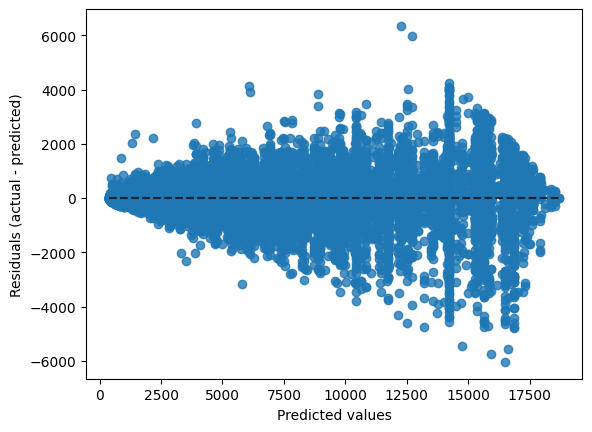

In [23]:
PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred).plot()

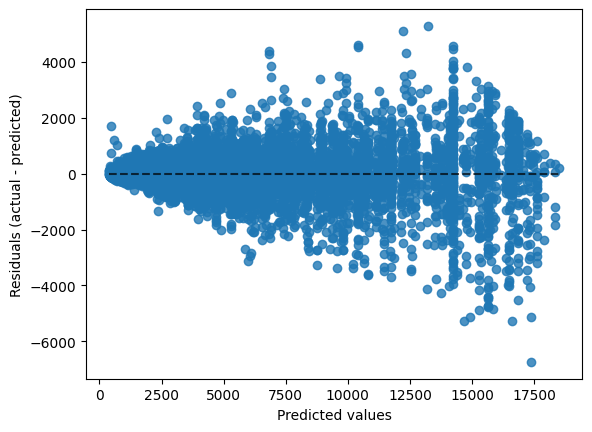

In [24]:
PredictionErrorDisplay(y_true=y_test, y_pred=y_test_pred).plot()

Видно, что существуют определённые "выбросы" в предсказании, но они довольно близки к общему распределению. 

Также стоит обратить внимание на то, что на test выборке существенно снизилась разница между настоящими и предсказанными значениями.

### Выводы

Относительно baseline удалось существенно улучшить работу модели на новых данных.

Также удалось выделить наиболее важные фичи при предсказании целевой переменной.

In [25]:
import joblib

In [26]:
joblib.dump(gridsearch.best_estimator_, '../model/pipeline.joblib')

['./model/pipeline.joblib']